## DataSet Preproccessing

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Let's start with our data preprocessing. First, we will read the file and remove the “date,” “country,” and “street” columns, as they do not provide relevant information for our prediction.

We will also compare sqft_living and the sum of sqft_above+sqft_basement to check if the sum is equal.

In [ ]:
df = pd.read_csv("archive/data.csv")

df = df.drop(columns=["date", "country", "street"])

#df["was_renovated"] = (df["yr_renovated"] > 0).astype(int)


df["sqft_sum"] = df["sqft_above"] + df["sqft_basement"]
df["sqft_diff"] = df["sqft_living"] - df["sqft_sum"]
df["sqft_diff_pct"] = np.abs(df["sqft_diff"]) / df["sqft_living"]


print("Consistency between sqft_living and sqft_above+sqft_basement:")
print(df["sqft_diff_pct"].describe())

inconsistentes = df[df["sqft_diff_pct"] > 0.05]
print(f"\nRows with unconsistency >5%: {len(inconsistentes)}")
display(inconsistentes[["sqft_living", "sqft_above", "sqft_basement", "sqft_sum", "sqft_diff"]].head())

Consistency between sqft_living and sqft_above+sqft_basement:
count    4600.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: sqft_diff_pct, dtype: float64

Rows with unconsistency >5%: 0


,sqft_living,sqft_above,sqft_basement,sqft_sum,sqft_diff


In [4]:
df = df.drop(columns=["sqft_diff_pct", "sqft_sum", "sqft_diff"])

As we have seen, the sum is the same, so we can now delete the variables created to continue processing our data.

Here we apply a feature engineering technique that involves converting the price to the logarithm of the price in order to distribute the data more evenly.

In [5]:
df["log_price"] = np.log(df["price"])
display(df[["price","log_price"]].head())

/Users/toni/Documents/MESIIA/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,price,log_price
0,313000.0,12.653958
1,2384000.0,14.684290
2,342000.0,12.742566
3,420000.0,12.948010
4,550000.0,13.217674


In [6]:
invalid_prices = df[(df["price"] <= 0) | (df["price"].isna())]
print(f"Rows with price <= 0 o NaN: {len(invalid_prices)}")

if len(invalid_prices) > 0:
    display(invalid_prices[["price"]].head())

df = df[df["price"] > 0].copy()

df["log_price"] = np.log(df["price"])

Rows with price <= 0 o NaN: 49


,price
4354,0.0
4356,0.0
4357,0.0
4358,0.0
4361,0.0


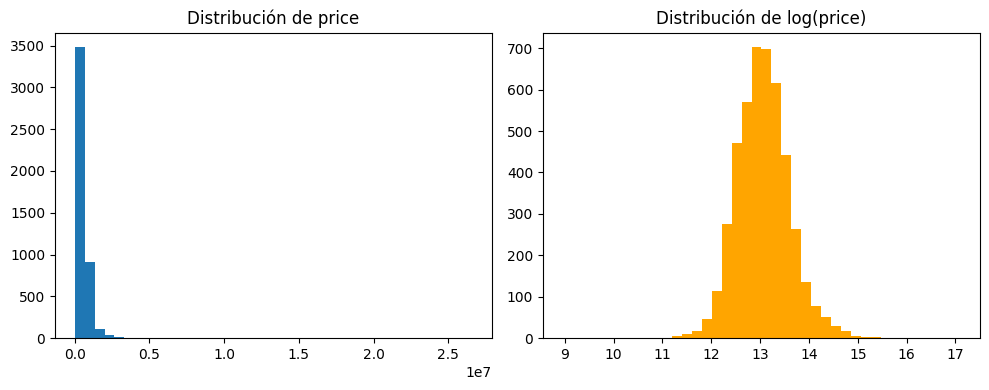

In [7]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df["price"], bins=40)
plt.title("Distribución de price")

plt.subplot(1,2,2)
plt.hist(df["log_price"], bins=40, color='orange')
plt.title("Distribución de log(price)")

plt.tight_layout()
plt.show()


Once this was done, we decided it would be interesting to create some synthetic variables, namely “house_age” and “since_renovation,” to see if we could add value to our dataset.

In [9]:
df["house_age"] = 2014 - df["yr_built"]


df["since_renovation"] = np.where(
    df["yr_renovated"] > 0,
    2014 - df["yr_renovated"],
    df["house_age"]
)


display(df[["yr_built", "yr_renovated", "house_age", "since_renovation", "was_renovated"]].head())

print("\nResumen estadístico de las nuevas variables:")
display(df[["house_age", "since_renovation"]].describe())


,yr_built,yr_renovated,house_age,since_renovation,was_renovated
0,1955,2005,59,9,1
1,1921,0,93,93,0
2,1966,0,48,48,0
3,1963,0,51,51,0
4,1976,1992,38,22,1



Resumen estadístico de las nuevas variables:


,house_age,since_renovation
count,4551.000000,4551.000000
mean,43.204351,28.909910
std,29.760073,26.852954
min,0.000000,0.000000
25%,17.000000,9.000000
50%,38.000000,20.000000
75%,63.000000,40.000000
max,114.000000,114.000000


Here we can see the distribution of our numerical data to see how they are positioned and detect possible outliers. We will accompany this with a correlation map and a correlation statistic with log(price) to see which variables may be most related to our price.

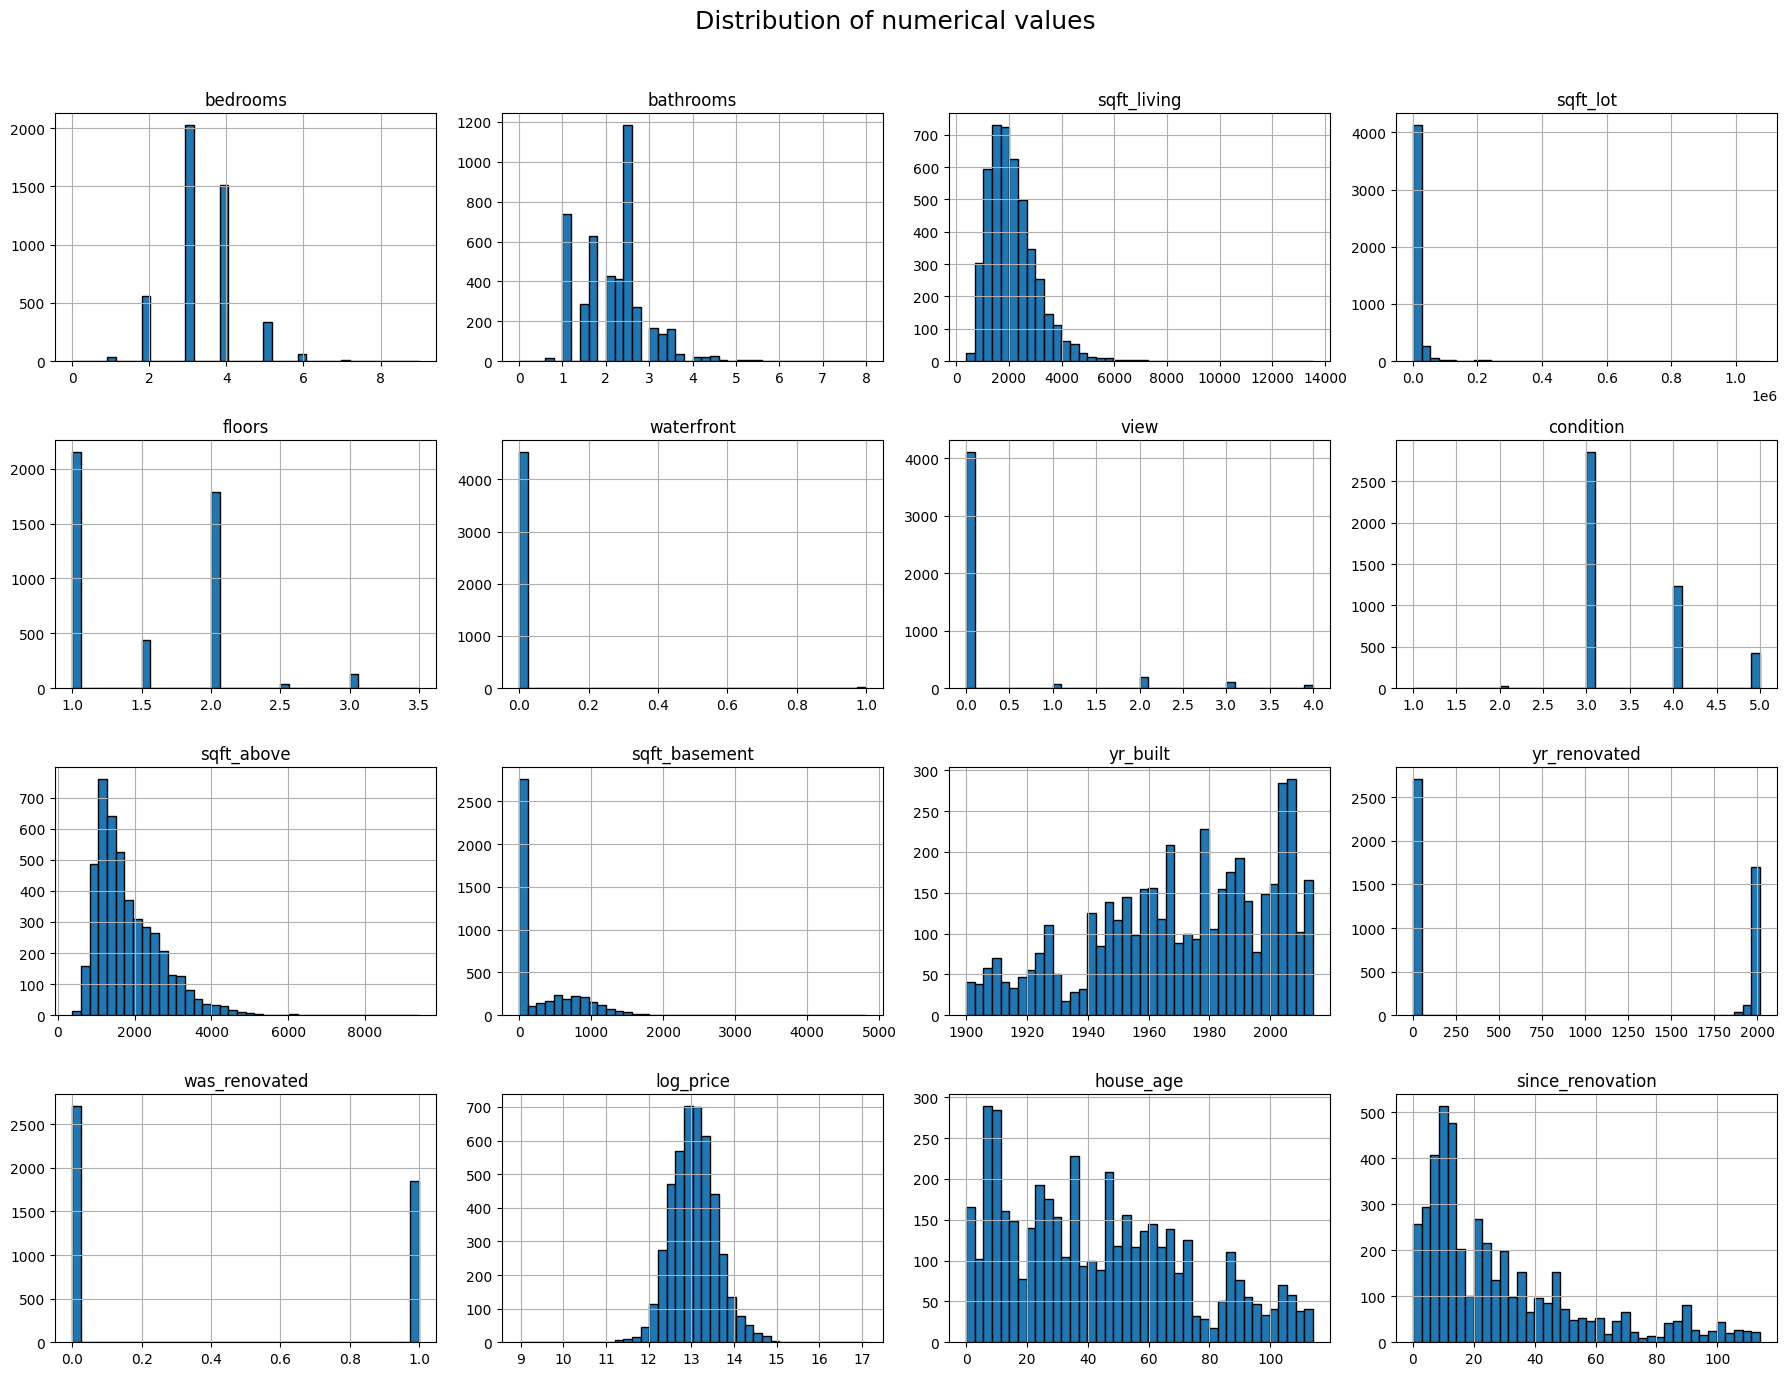

In [12]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(['price'], errors='ignore')

df[numeric_cols].hist(figsize=(18, 14), bins=40, edgecolor='black')
plt.suptitle("Distribution of numerical values", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Correlaciones con log_price:


log_price           1.000000
price               0.677507
sqft_living         0.671307
sqft_above          0.582012
bathrooms           0.548583
bedrooms            0.355346
view                0.324040
sqft_basement       0.312636
floors              0.305319
waterfront          0.141863
sqft_lot            0.085856
condition           0.059256
yr_built            0.059101
since_renovation   -0.000911
house_age          -0.059101
was_renovated      -0.062616
yr_renovated       -0.063173
Name: log_price, dtype: float64

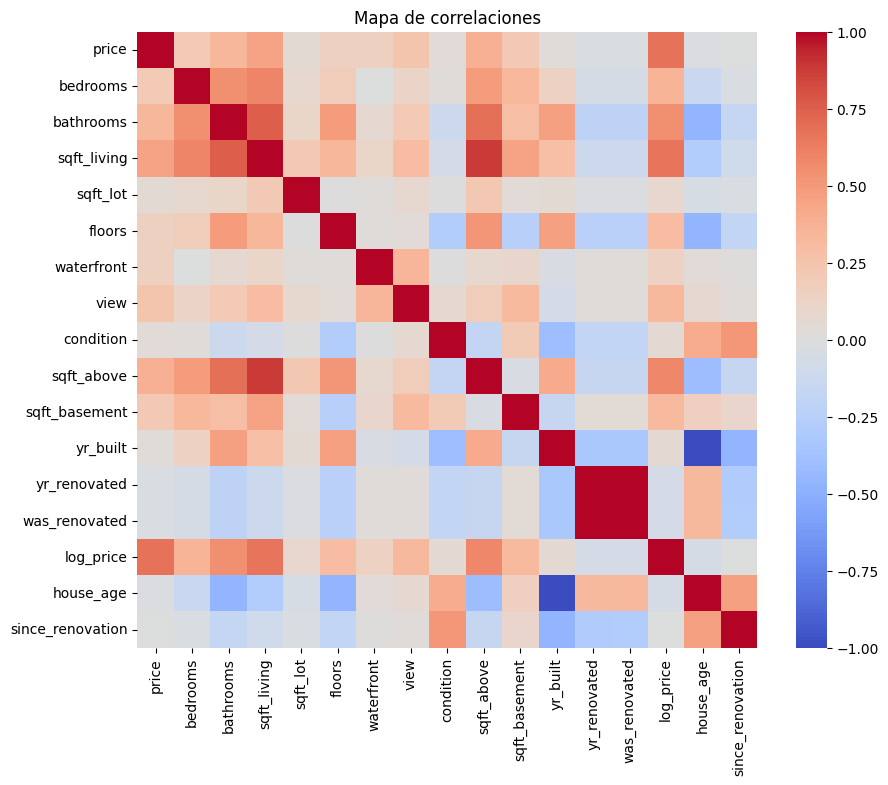

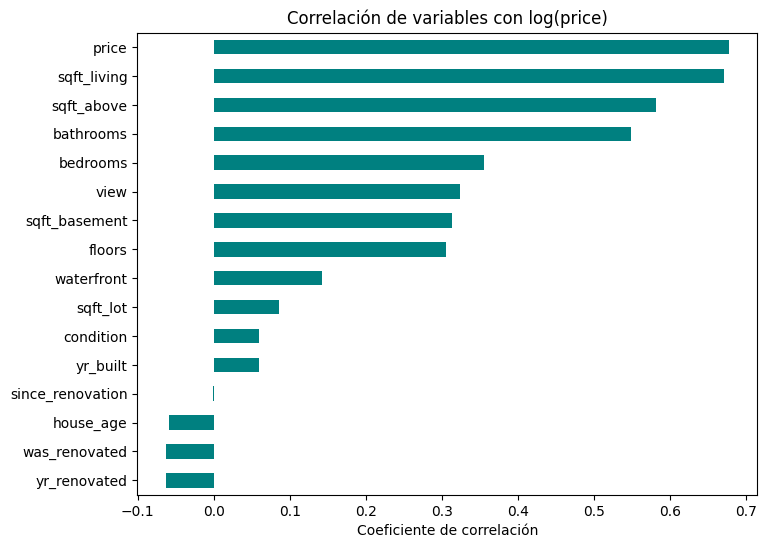

In [13]:
corr = df.corr(numeric_only=True)

corr_logprice = corr["log_price"].sort_values(ascending=False)

print("Correlaciones con log_price:")
display(corr_logprice)

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Mapa de correlaciones")
plt.show()

plt.figure(figsize=(8,6))
corr_logprice.drop("log_price").sort_values().plot(kind="barh", color='teal')
plt.title("Correlación de variables con log(price)")
plt.xlabel("Coeficiente de correlación")
plt.show()


Let's make a graph of the distribution of the data where most of it is located for now, if we apply outlier removal to the data most related to log(price).

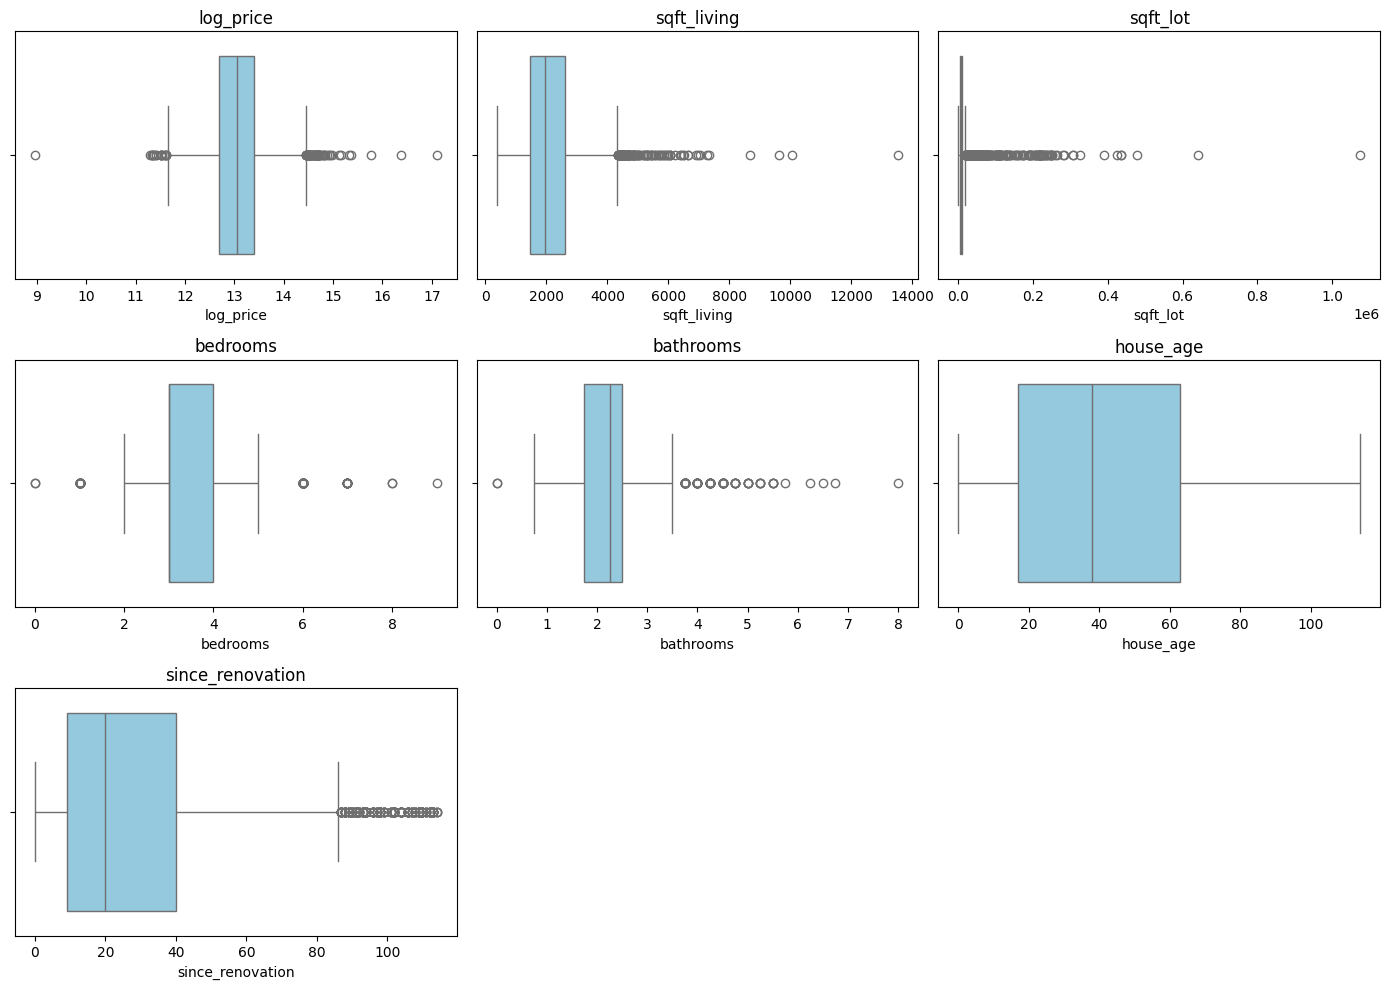

In [14]:
key_vars = ["log_price", "sqft_living", "sqft_lot", "bedrooms", "bathrooms", "house_age", "since_renovation"]

plt.figure(figsize=(14, 10))
for i, col in enumerate(key_vars):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.show()


log_price: Deleted 78 outliers
sqft_living: Deleted 97 outliers
sqft_lot: Deleted 498 outliers

Original Rows: 4551, Rows after cleaning: 3878


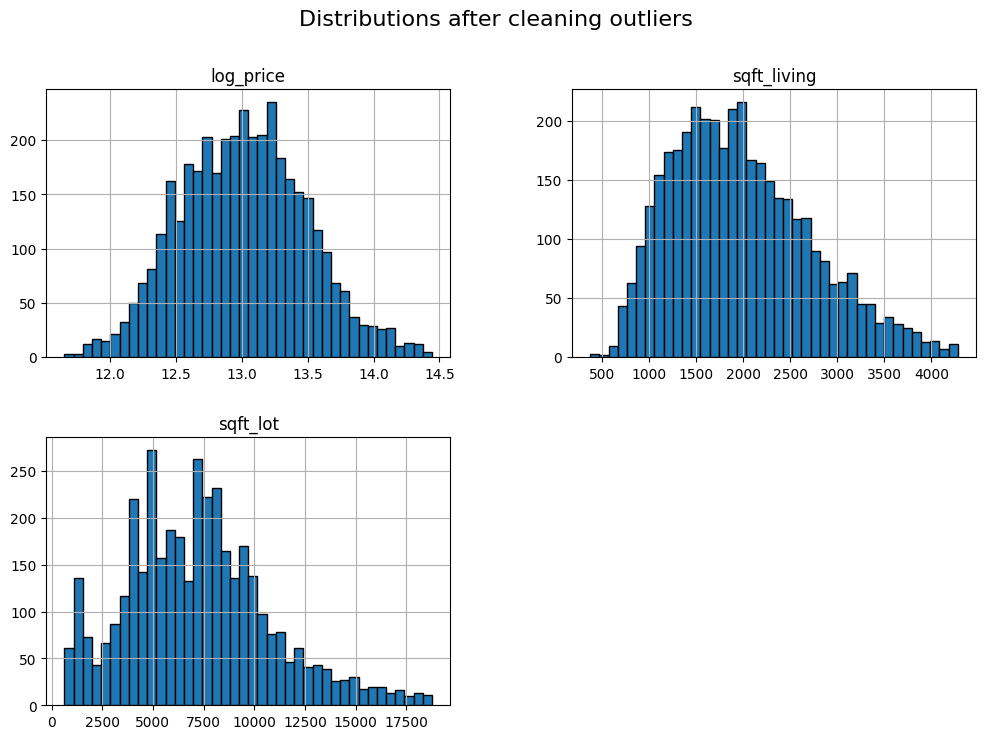

In [18]:
vars_to_clean = ["log_price", "sqft_living", "sqft_lot"]

df_clean = df.copy()

def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    filtered_data = data[(data[column] >= lower) & (data[column] <= upper)]
    print(f"{column}: Deleted {len(data)-len(filtered_data)} outliers")
    return filtered_data

for col in vars_to_clean:
    df_clean = remove_outliers_iqr(df_clean, col)

print(f"\nOriginal Rows: {len(df)}, Rows after cleaning: {len(df_clean)}")

df_clean[vars_to_clean].hist(figsize=(12,8), bins=40, edgecolor='black')
plt.suptitle("Distributions after cleaning outliers", fontsize=16)
plt.show()


## DataSplitting

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [22]:
X = df_clean.drop(columns=["log_price", "price"], axis = 1)
y = df_clean["log_price"]

In [28]:
X = pd.get_dummies(X, drop_first=True)  # drop_first=True evita multicolinealidad


In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
mlr = LinearRegression()

mlr.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [ ]:
y_pred = mlr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse}")
print(f"R2: {r2}")

MSE: 0.03997393956210819
R2: 0.8242163729767608


/Users/toni/Documents/MESIIA/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/toni/Documents/MESIIA/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/toni/Documents/MESIIA/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
